#### General import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint
import time, os, json

import os
os.chdir("..")
import src.models as mm
from src.models import logger
import src.visualizations as mv
import src.envs as envs

from tools.utils import clf, tqdm_enumerate, save_image

%load_ext autoreload
%autoreload 2

plt.style.use('classic')
logger()

ModuleNotFoundError: No module named 'src.envs'

## Gridworld

In [1]:
from __future__ import annotations

from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv

pygame 2.5.2 (SDL 2.28.3, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        #self.grid.wall_rect(0, 0, width, height)

        # Generate vertical separation wall
        for i in range(0, height):
            self.grid.set(5, i, Wall())
        
        # Place the door and key
        self.grid.set(5, 6, Door(COLOR_NAMES[0], is_locked=True))
        self.grid.set(3, 6, Key(COLOR_NAMES[0]))

        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), width - 2, height - 2)

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"


def main():
    env = SimpleEnv(render_mode="human")

    # enable manual control for testing
    manual_control = ManualControl(env, seed=42)
    manual_control.start()

In [ ]:
print("hello")

In [7]:
env.step(0)

AttributeError: 'SimpleEnv' object has no attribute 'step_count'

In [3]:
env = SimpleEnv(render_mode="human")

# enable manual control for testing
manual_control = ManualControl(env, seed=42)
#manual_control.start()

In [16]:
env.get_pov_render(tile_size=1)

AssertionError: invalid agent direction

### Envs

2024-05-13 23:36:50 | Flatland(width=20, height=20, #walls=7)


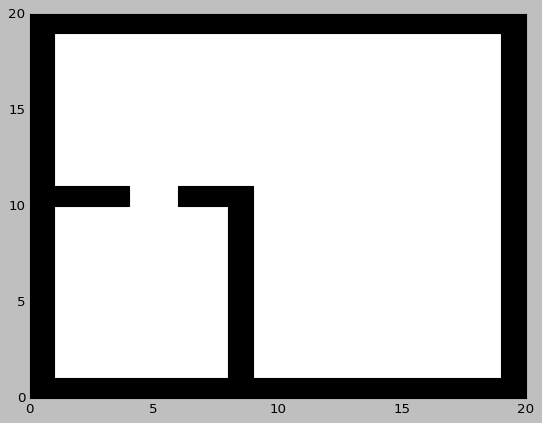

In [106]:
walls = [envs.Wall(x=0, y=0, width=1, height=20),
         envs.Wall(x=0, y=19, width=20, height=1),
         envs.Wall(x=19, y=0, width=1, height=20),
         envs.Wall(x=0, y=0, width=20, height=1),
         envs.Wall(x=8, y=0, width=1, height=10),
         envs.Wall(x=1, y=10, width=3, height=1),
         envs.Wall(x=6, y=10, width=3, height=1),
        ]

env = envs.Flatland(width=20, height=20, walls=walls)

logger(env)

env.draw()

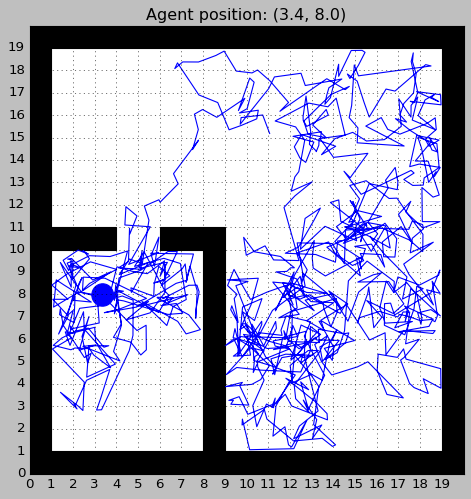

In [113]:
""" simulation """
agent = envs.Agent(x=13, y=15, speed=0.75, radius=0.5)
sim = envs.Simulation(flatland=env, agent=agent, n_steps=1000, start_position=(11, 15))
logger(agent)
logger(sim)

""" run """
sim.run()

## RatInABox

In [1]:
#ratinabox stuff
import ratinabox
from ratinabox.Agent import Agent
from ratinabox.Neurons import PlaceCells
from ratinabox.contribs.NeuralNetworkNeurons import NeuralNetworkNeurons #for the Actor and Critic

#misc
import torch 
import numpy as np 
from gymnasium.spaces import Box
from tqdm import tqdm
import time

#autoreload while in dev mode
%load_ext autoreload
%autoreload 2

pygame 2.5.2 (SDL 2.28.3, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


**SETTINGS**

In [22]:
#TASK CONSTANTS
DT = 0.1 # Time step
T_TIMEOUT = 15 # Time out
GOAL_POS = np.array([0.5, 0.5]) # Goal position
WALL = None
GOAL_RADIUS = 0.1
REWARD = 1 # Reward
REWARD_DURATION = 1 # Reward duration

#LEARNING CONSTANTS
TAU = 5 # Discount time horizon
TAU_E = 5 # Eligibility trace time horizon
ETA = 0.01 # Learning rate 
N_EPISODES = 3000 # Number of episodes
L2 = 0.000 # L2 regularization

#### Environment

In [19]:
#visualisations
import matplotlib 
import matplotlib.pyplot as plt 

def display_reward_patch(fig, ax, reward_pos=GOAL_POS, reward_radius=GOAL_RADIUS, **kwargs): #we'll also use this later 
    """Plots the reward patch on the given axis"""
    circle = matplotlib.patches.Circle(reward_pos, radius=reward_radius,
                                       facecolor='r', alpha=0.2, color=None) 
    ax.add_patch(circle)
    return fig, ax 


def plot_reward_history(env, smooth=100):
    """Takes an environment and used its episode data to diplay the time series of rewards and the same data smoothed over `smooth` episodes"""
    fig, ax = plt.subplots(figsize=(6,2))
    data = env.episodes
    episodes = data['episode'][:-1]
    durations = data['duration']
    smoothed_durations = np.convolve(durations, np.ones(smooth)/smooth, mode='full')[:len(durations)]
    ax.scatter(episodes,durations,alpha=0.4)
    ax.plot(episodes[smooth:],smoothed_durations[smooth:])
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Duration")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,max(durations)+0.1)
    return fig, ax

def ego_to_allo(v_ego, head_direction):
    """Converts an egocentric velocity vector to an allocentric one by by rotating it by the bearing of the agents current head direction"""
    bearing = ratinabox.utils.get_bearing(head_direction)
    v_allo = ratinabox.utils.rotate(v_ego, -bearing) #bearing measured clockwise from north, so we rotate anticlockwise by -bearing
    return v_allo

In [9]:
from ratinabox.contribs.TaskEnvironment import (SpatialGoalEnvironment, SpatialGoal, Reward)

def generate_navigation_task_env():
    
    # Make the environment and add a wall 
    env = SpatialGoalEnvironment(
        dt=DT,
        teleport_on_reset=True,
        episode_terminate_delay=REWARD_DURATION,)
    env.exploration_strength = 1 
    if WALL is not None: env.add_wall(WALL)
    #Make the reward which is given when a spatial goal is satisfied. Attached this goal to the environment
    reward = Reward(REWARD,decay="none",expire_clock=REWARD_DURATION,dt=DT,)
    goals = [SpatialGoal(env,pos=GOAL_POS,goal_radius=GOAL_RADIUS, reward=reward)]
    env.goal_cache.reset_goals = goals 

    # Recruit the agent and add it to environment
    ag = Agent(env,params={'dt':DT})
    env.add_agents(ag) #<-- this updates the agent creating an off by one error 

    # add cells
    PCs = PlaceCells(
    ag,
    params={
        "n": 100,
        "description": "gaussian_threshold",
        "widths": 0.40,
        "wall_geometry": "line_of_sight",
        "max_fr": 10,
        "min_fr": 0.1,
        "color": "C1",
    },
    )

    cells = [PCs]
    #return env, ag
    return SuperEnv(env=env, cells=cells), ag

class SuperEnv:

    def __init__(self, env, cells):

        self._env = env
        self._cells = cells
        self.t = env.t
        self.episodes = env.episodes

    def step1(self, args=None):

        obs, reward, terminate, truncated, info = self._env.step1()
        self.t = self._env.t
        self.episodes = self._env.episodes

        for c in self._cells:
            c.update()
            obs = np.concatenate((obs, c.firingrate))

        #obs = n.c.. (env_return[0], c.firingrate)

        return obs, reward, terminate, truncated, info

    def reset(self, episode_meta_info):

        self._env.reset(episode_meta_info=episode_meta_info)
        


Under the random policy the Agent completed the task 1 times and timed-out 9 times.



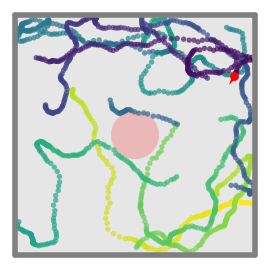

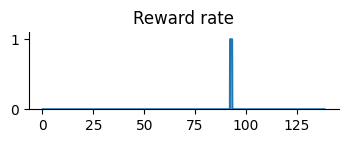

In [37]:
env, ag = generate_navigation_task_env() # make the task environment and agent

rewards = [] # For plotting
#while env.t < 300: 
while len(env.episodes['episode']) < 11:
    observation, reward_rate, terminate_episode, _ , info =  env.step1()
    
    # check
    if env.t - env.episodes['start'][-1] > T_TIMEOUT:
        env.reset(episode_meta_info="timeout")
        
    elif terminate_episode:
        env.reset(episode_meta_info="completed")
        
    rewards.append(reward_rate)

print(f"Under the random policy the Agent completed the task {(np.array(env.episodes['meta_info']) == 'completed').sum()}" + \
      f" times and timed-out {(np.array(env.episodes['meta_info']) == 'timeout').sum()} times.\n")

#display the trajectory 
fig, ax = ag.plot_trajectory(color="changing")
display_reward_patch(fig,ax)

#show the reward timeseries
fig, ax = plt.subplots(figsize=(4,1))
ax.plot(ag.history["t"],rewards)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.set_ylim(0,max(rewards)+0.1)
ax.set_title("Reward rate")
plt.show()

In [54]:
help(env._env.action_space)

Help on method action_space in module ratinabox.contribs.TaskEnvironment:

action_space(agent_name: str) method of ratinabox.contribs.TaskEnvironment.SpatialGoalEnvironment instance
    Takes in agent and returns the action space for that agent.
    
    MUST return the same value for the same agent name
    
    Default implementation is to return the action_spaces dict



In [47]:
dir(env._env.Agents[0])

['Environment',
 'Neurons',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_and_handle_wall_collisions',
 '_drift_velocity_update',
 '_history_arrays',
 '_last_history_array_cache_time',
 '_measure_velocity_of_step_taken',
 '_stochastic_velocity_update',
 '_update_distance_travelled',
 '_update_head_direction',
 '_update_position_along_imported_trajectory',
 '_update_position_to_forced_next_position',
 '_wall_velocity_update',
 'agent_idx',
 'animate_trajectory',
 'average_measured_speed',
 'default_params',
 'distance_to_closest_wall',
 'distance_travelled',
 'dt',
 'get_all_default_params',
 'get_history_arrays',
 'get_history_slice',
 'head_

In [40]:
help(env._env.step1)

Help on method step1 in module ratinabox.contribs.TaskEnvironment:

step1(action=None, *pos, **kws) method of ratinabox.contribs.TaskEnvironment.SpatialGoalEnvironment instance
    shortcut for stepping when only 1 agent exists...makes it behave
    like gymnasium instead of pettingzoo



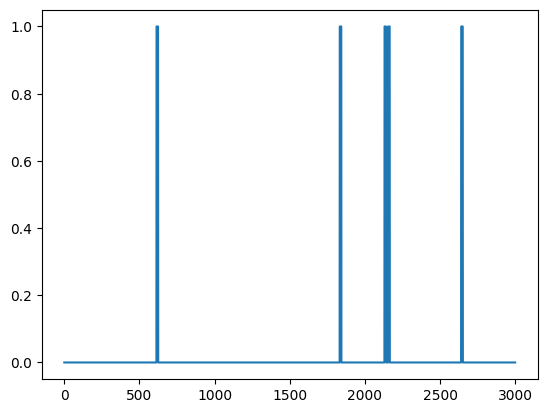

In [24]:
plt.plot(np.array(rewards));

In [13]:
env._cells[0].firingrate

array([0.1       , 0.1       , 0.1       , 2.89744834, 2.73964337,
       5.58996005, 7.10479504, 5.06528073, 1.05489065, 0.76888105,
       0.1       , 0.1       , 0.85677782, 2.85231129, 7.85124032,
       8.49208055, 7.83762532, 7.78396525, 5.82893917, 2.24644359,
       0.1       , 0.1       , 1.28042321, 5.07996345, 8.26483591,
       9.86218041, 9.59907264, 7.58710901, 4.79558171, 2.64847596,
       0.1       , 0.1       , 2.3651882 , 2.9841526 , 6.43406763,
       9.69780566, 9.35743351, 7.76800421, 5.62345166, 1.20239071,
       0.1       , 0.1       , 0.1       , 1.64547068, 7.01228258,
       7.47951756, 6.7674224 , 6.65903101, 3.05365295, 0.24409328,
       0.1       , 0.1       , 0.1       , 2.20223622, 4.77767583,
       4.68590993, 3.31452968, 3.80909723, 0.23376458, 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.84814933, 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1    

In [12]:
observation

array([0.61502438, 0.27449975, 0.1       , 0.1       , 0.1       ,
       2.89744834, 2.73964337, 5.58996005, 7.10479504, 5.06528073,
       1.05489065, 0.76888105, 0.1       , 0.1       , 0.85677782,
       2.85231129, 7.85124032, 8.49208055, 7.83762532, 7.78396525,
       5.82893917, 2.24644359, 0.1       , 0.1       , 1.28042321,
       5.07996345, 8.26483591, 9.86218041, 9.59907264, 7.58710901,
       4.79558171, 2.64847596, 0.1       , 0.1       , 2.3651882 ,
       2.9841526 , 6.43406763, 9.69780566, 9.35743351, 7.76800421,
       5.62345166, 1.20239071, 0.1       , 0.1       , 0.1       ,
       1.64547068, 7.01228258, 7.47951756, 6.7674224 , 6.65903101,
       3.05365295, 0.24409328, 0.1       , 0.1       , 0.1       ,
       2.20223622, 4.77767583, 4.68590993, 3.31452968, 3.80909723,
       0.23376458, 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.84814933, 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1    

In [55]:
env._env.D

2

In [80]:
from gymnasium.utils.env_checker import check_env

In [84]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
#from stable_baselines3.common.env_checker import check_env

class SimpleLineEnv(gym.Env):
    """
    A simple environment where the agent moves on a 1-dimensional line between 0 and 10.
    The goal is to reach the position 10 starting from 0.
    """
    def __init__(self):
        super(SimpleLineEnv, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        self.action_space = spaces.Discrete(2)  # 0: Move left, 1: Move right
        self.observation_space = spaces.Box(low=0, high=10, shape=(1,), dtype=np.float32)
        
        # Initial condition
        self.state = 0

    def step(self, action):
        if action == 1:
            self.state += 1
        elif action == 0:
            self.state -= 1

        self.state = np.clip(self.state, 0, 10)
        
        # Reward function
        reward = 1 if self.state == 10 else -1

        # Episode is done when the agent reaches 10
        done = bool(self.state == 10)

        # Optionally we can pass additional info, we are not using that for now
        info = {}

        return np.array([self.state]).astype(np.float32), reward, done, _, info

    def reset(self, seed=None, **kwargs):
        self.state = 0
        super().reset(seed=seed)
        return np.array([self.state]).astype(np.float32), {}

    def render(self, mode='human', **kwargs):
        print(f"Current state: {self.state}")

    def close(self):
        pass

# Create an instance of the environment
env = SimpleLineEnv()

# Check the environment
check_env(env)

/Users/daniekru/Research/codebase/myenvs/env_cl1/lib/python3.11/site-packages/gymnasium/utils/env_checker.py:321: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantialising the environment through gymnasium.make
  logger.warn(


In [81]:
check_env(env)

Error: The `reset` method does not provide an `options` or `**kwargs` keyword argument.

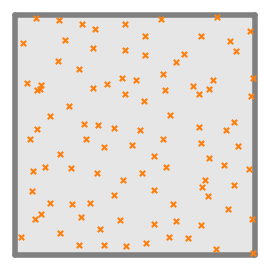

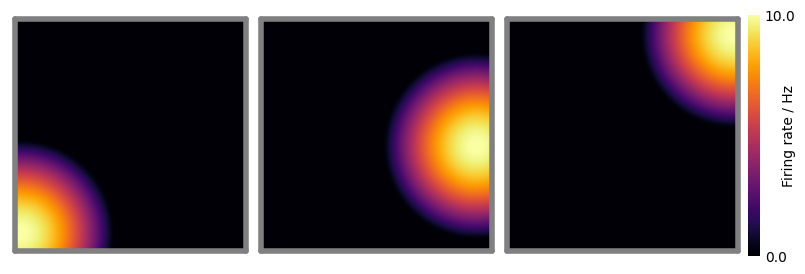

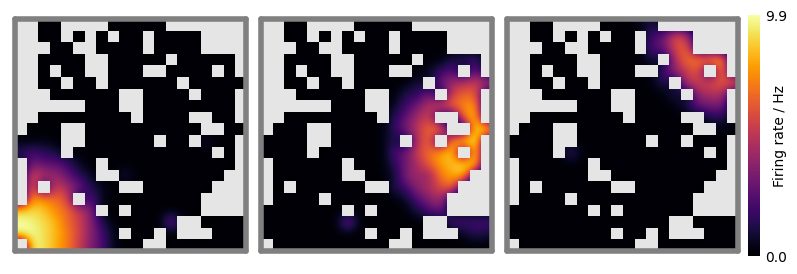

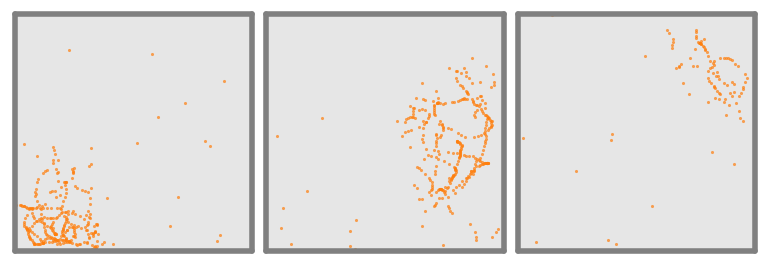

In [65]:
# 9 Plot place cell locations.
PCs = env._cells[0]
fig, ax = PCs.plot_place_cell_locations()

# 10 Plot rate maps (first analytically, second using bin exploration data, third using observed spikes ) .
fig, ax = PCs.plot_rate_map(chosen_neurons="3", method="groundtruth")
fig, ax = PCs.plot_rate_map(chosen_neurons="3", method="history")
fig, ax = PCs.plot_rate_map(chosen_neurons="3", method="neither", spikes=True)




-------------------------
New environment

In [ ]:
from gym import spaces
import gymnasium as gym
from stable_baselines3 import A2C, PPO

import sys, os
sys.path.append(os.path.expanduser('~/Research/lab/PCNN/src/rl/smoothworld'))
import envs as se
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

""" train PPO agent """

T_TIMEOUT = 100
EPOCHS = 100

# Optionally check the environment (useful during
# development)
env, agent = se.generate_navigation_task_env(IS_PCNN_flag=True)

# model = A2C("MlpPolicy", env, verbose=1)
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
)

for _ in tqdm(range(EPOCHS)):
    model.learn(total_timesteps=T_TIMEOUT,
                log_interval=100,
                progress_bar=False)

In [ ]:
#### Test

obs, _ = env.reset()
rewards = 0

# agent.reset_history()

t_start = env.t
positions = []

while env.t < (T_TIMEOUT+t_start):

    action, _state = model.predict(obs, deterministic=True)
    observation, reward_rate, done, _ , info =  env.step(action=action)

    positions += [env._env.agents_dict['agent_0'].pos.tolist()]

    # exit
    if done:
        break

# display the trajectory
# slice = agent.get_history_slice(t_start=env.t-T_TIMEOUT*agent.dt,
#                                 t_end=env.t,
#                                 framerate=30)
# history_data = agent.get_history_arrays() # gets history dataframe as dictionary of arrays
# trajectory = history_data["pos"][slice]
fig, ax = plt.subplots()
fig, ax = agent.plot_trajectory(fig=fig, ax=ax, t_start=env.t-1000,
                                t_end=env.t,
                                framerate=30)
env._env.plot_environment(autosave=False, fig=fig, ax=ax)
# ax.plot(trajectory[:, 0], trajectory[:, 1], 'k-', alpha=0.25, lw=1)
# ax.scatter(trajectory[-1, 0], trajectory[-1, 1], c='g', s=100, marker='>')

# display the reward patch
fig, ax = se.display_reward_patch(fig, ax)


positions = np.array(positions)

plt.plot(1-positions[0, :], positions[1, :], '-k')

plt.show()


